In [1]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def getCloseData(ticker, start, end=None):
    """
    종가 데이터
    ticker: 종목 번호
    start: 시작일
    end: 마지막 날짜
    return: 종목의 종가 데이터
    """
    return fdr.DataReader(ticker, start, end)['Close']

def getDayReturn(closeDataSet):
    """
    개별종목 일별 수익률
    closeDataSet: 종가 데이터
    return: 종가 데이터의 일별 수익률
    """
    return (closeDataSet / closeDataSet.shift(1)).fillna(1)

def getCumulativeReturn(closeDataSet):
    """
    개별종목 누적수익률 == 자산흐름
    closeDataSet: 종가 데이터
    return:종가데이터 누적수익률
    """
    return closeDataSet / closeDataSet.iloc[0]

def getPortfolioResult(closeDataSet, weight=None):
    """
    포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    # 개별종목 일별 수익률
    dayReturn = getDayReturn(closeDataSet)
    # 개별종목 누적 수익률
    cumulativeReturn = getCumulativeReturn(closeDataSet)
    # 자산별 비중. 기본값: 동일비중
    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)

    # 포트폴리오 누적 수익률
    portfolioCumulativeReturn = (weight * cumulativeReturn).sum(axis=1)
    # 포트폴리오 일별 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)
    return portfolioDayReturn, portfolioCumulativeReturn

def getEvaluation(cumulativeReturn):
    """
    cagr, dd, mdd
    투자 성과 지표
    """
    # cagr
    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    # mdd
    dd = (cumulativeReturn.cummax() - cumulativeReturn) / cumulativeReturn.cummax() * 100
    mdd= dd.max()

    print(f"최종 수익률: {cumulativeReturn.iloc[-1]}\ncagr: {cagr}\nmdd: {mdd}")

    return cagr, dd, mdd

def getRebalancingDate(closeDataSet, period="month"):
    """
    리밸런싱 일자 추출
    월별, 분기별, 연별
    """
    data = closeDataSet.copy()
    data = pd.DataFrame(data)
    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month

    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index

    if period == "quarter":
        # 3 6 9 12월 말에 리밸런싱
        # np where 같은걸로 3, 6, 9, 12월 데이터만 가져오고
        # drop_duplicates keep last 하면 됌
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index

    if period == "year":
        rebalancingDate = data.drop_duplicates(['year'], keep="last").index

    return rebalancingDate

def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):
    """
    리밸런싱 포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """

    # 자산별 비중. 기본값: 동일비중
    if weightDf is None:
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)] * len(rebalancingDate),
                                index=rebalancingDate,
                                columns=closeDataSet.columns)
    # 자산별 비중이 있는 경우
    else:
        closeDataSet = closeDataSet.loc[weightDf.index[0]:]
        rebalancingDate = weightDf.index # 리밸런싱 날짜

    portfolio = pd.DataFrame() # 빈 데이터 프레임 생성

    totalAsset = 1 # 총 자산, 초기값 1
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

    for end in rebalancingDate[1:]:
        weight = weightDf.loc[start] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익률
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영

        start = end # start 갱신
        totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가

    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터 제거
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1) # 포트폴리오 일간 수익률

    return portfolioDayReturn, portfolioCumulativeReturn

def getWeightByAvgMomentumScore(closeDataSet, n = 12):
    """
    평균 모멘텀 스코어를 기반으로 한 투자 비중 구하기
    closeDataSet: 종가 데이터
    n: 모멘텀 기간 1~n
    return: 투자비중 weight df, 평균모멘텀 스코어 df
    """
    avgMomentumScore = 0 # 평모스 초기값
    priceOnRebalDate = closeDataSet.loc[getRebalancingDate(closeDataSet)] # 리밸런싱 일자의 가격 데이터

    # 1 ~ n개월 모멘텀 스코어 합
    for i in range(1, n+1):
        avgMomentumScore = np.where(priceOnRebalDate / priceOnRebalDate.shift(i) > 1, 1, 0) + avgMomentumScore

    # 평모스 계산
    avgMomentumScore = pd.DataFrame(avgMomentumScore, index=priceOnRebalDate.index, columns=priceOnRebalDate.columns) # dataframe 형변환
    avgMomentumScore = avgMomentumScore / n

    # 모멘텀 스코어에 따른 weight 계산
    weight = avgMomentumScore.divide(avgMomentumScore.sum(axis=1), axis=0).fillna(0)
    # 투자 비중이 모두 0인 구간에서는 현금 보유
    weight['cash'] = np.where(weight.sum(axis=1) == 0, 1, 0)

    # 투자비중, 평모스 리턴
    return weight, avgMomentumScore


## 모멘텀 계산방법

In [4]:
# 데이터로드
kodex200 = getCloseData("069500", "2023")
kodex200

Date
2023-01-02    28717
2023-01-03    28717
2023-01-04    29324
2023-01-05    29558
2023-01-06    29874
              ...  
2024-03-20    36720
2024-03-21    37715
2024-03-22    37605
2024-03-25    37455
2024-03-26    37825
Name: Close, Length: 303, dtype: int64

In [5]:
# 매월 말 리밸런싱
rebalDate = getRebalancingDate(kodex200)
rebalDate

DatetimeIndex(['2023-01-31', '2023-02-28', '2023-03-31', '2023-04-28',
               '2023-05-31', '2023-06-30', '2023-07-31', '2023-08-31',
               '2023-09-27', '2023-10-31', '2023-11-30', '2023-12-28',
               '2024-01-31', '2024-02-29', '2024-03-26'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [6]:
# 리밸런싱 일자 종가데이터
priceOnRebalDate = kodex200.loc[rebalDate]
priceOnRebalDate

Date
2023-01-31    31461
2023-02-28    31214
2023-03-31    31983
2023-04-28    32358
2023-05-31    33692
2023-06-30    33682
2023-07-31    34426
2023-08-31    33372
2023-09-27    32677
2023-10-31    30574
2023-11-30    33860
2023-12-28    36069
2024-01-31    33830
2024-02-29    35835
2024-03-26    37825
Name: Close, dtype: int64

### n개월 모멘텀 = 현재 가격 / n개월 전 가격

In [13]:
# n개월 모멘텀 구하기
# n개월 모멘텀 = 현재 가격 / n개월 전 가격
# n개월 수익률과 같은 개념
n = 1
momentum = (priceOnRebalDate / priceOnRebalDate.shift(n)).fillna(0)
momentum

Date
2023-01-31    0.000000
2023-02-28    0.992149
2023-03-31    1.024636
2023-04-28    1.011725
2023-05-31    1.041226
2023-06-30    0.999703
2023-07-31    1.022089
2023-08-31    0.969384
2023-09-27    0.979174
2023-10-31    0.935643
2023-11-30    1.107477
2023-12-28    1.065239
2024-01-31    0.937925
2024-02-29    1.059267
2024-03-26    1.055532
Name: Close, dtype: float64

### n개월 모멘텀 스코어 : if n개월 모멘텀 > 1, 1, 0

In [8]:
# n개월 모멘텀 스코어
# 개월 모멘텀 스코어: if n개월 모멘텀 > 1, 1, 0
n = 1
momentumScore = np.where(priceOnRebalDate / priceOnRebalDate.shift(n) > 1, 1, 0)
momentumScore

array([0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1])

### n개월 평균 모멘텀 스코어: 1~n개월 모멘텀 스코어의 평균

In [15]:
n = 12
avgMomentumScore = 0
for i in range(1, n+1):
    avgMomentumScore = np.where(priceOnRebalDate / priceOnRebalDate.shift(i) > 1, 1, 0) + avgMomentumScore
avgMomentumScore = pd.DataFrame(avgMomentumScore, index=priceOnRebalDate.index)
avgMomentumScore = avgMomentumScore / n
avgMomentumScore

,0
Date,
2023-01-31,0.000000
2023-02-28,0.000000
2023-03-31,0.166667
2023-04-28,0.250000
2023-05-31,0.333333
2023-06-30,0.333333
2023-07-31,0.500000
2023-08-31,0.333333
2023-09-27,0.333333


### 평균모멘텀 스코어에 따른 투자 비중 계산

In [16]:
# 데이터 로드
kodex200 = getCloseData("069500", "2023", "2023-12-31") # 코스피200 ETF
kodex10Bond = getCloseData("152380", "2000", "2023-12-31") # kodex 국고채 10년물 ETF

# kodex200 = 069500
# kodex10Bond = 152380
# S&P500 = SPY
# 미국 7-10 국채 = IEF

closeDataSet = pd.concat([kodex200, kodex10Bond], axis=1)
closeDataSet.columns = ['kodex200', 'kodex10Bond']
closeDataSet.dropna(inplace=True)
closeDataSet

,kodex200,kodex10Bond
Date,,
2023-01-02,28717.0,61775
2023-01-03,28717.0,62590
2023-01-04,29324.0,62980
2023-01-05,29558.0,63105
2023-01-06,29874.0,63095
...,...,...
2023-12-21,34842.0,66110
2023-12-22,34952.0,66055
2023-12-26,35097.0,66350


In [17]:
# 리밸런싱 일자
rebalDate = getRebalancingDate(closeDataSet)
# 리밸런싱 일자 종가 데이터
priceOnRebalDate =  closeDataSet.loc[rebalDate]

In [18]:
# 12개월 평균모멘텀스코어 계산
n = 12
avgMomentumScore = 0
for i in range(1, n+1):
    avgMomentumScore = np.where(priceOnRebalDate / priceOnRebalDate.shift(i) > 1, 1, 0) + avgMomentumScore
avgMomentumScore = pd.DataFrame(avgMomentumScore, index=priceOnRebalDate.index, columns=priceOnRebalDate.columns)
avgMomentumScore = avgMomentumScore / n
avgMomentumScore

,kodex200,kodex10Bond
Date,,
2023-01-31,0.000000,0.000000
2023-02-28,0.000000,0.000000
2023-03-31,0.166667,0.166667
2023-04-28,0.250000,0.166667
2023-05-31,0.333333,0.083333
2023-06-30,0.333333,0.083333
2023-07-31,0.500000,0.083333
2023-08-31,0.333333,0.083333
2023-09-27,0.333333,0.000000


In [19]:
# 평균모멘텀 스코어에 따른 투자 비중 계산
# 2023-08-31 기준 투자 비중은  주식 : 0.333 / (0.333 + 0.084) 채권 :0.084 / (0.333 + 0.084)
# 둘다 0인 시즌은 둘다 하락하고 있으니 투자하지마라
# axis = 0 횡방향, 1 열방향
avgMomentumScore.sum(axis=1)

Date
2023-01-31    0.000000
2023-02-28    0.000000
2023-03-31    0.333333
2023-04-28    0.416667
2023-05-31    0.416667
2023-06-30    0.416667
2023-07-31    0.583333
2023-08-31    0.416667
2023-09-27    0.333333
2023-10-31    0.000000
2023-11-30    1.250000
2023-12-28    1.833333
dtype: float64

In [20]:
weight = avgMomentumScore.divide(avgMomentumScore.sum(axis=1), axis=0).fillna(0)
weight


,kodex200,kodex10Bond
Date,,
2023-01-31,0.000000,0.000000
2023-02-28,0.000000,0.000000
2023-03-31,0.500000,0.500000
2023-04-28,0.600000,0.400000
2023-05-31,0.800000,0.200000
2023-06-30,0.800000,0.200000
2023-07-31,0.857143,0.142857
2023-08-31,0.800000,0.200000
2023-09-27,1.000000,0.000000


In [21]:
# 주식, 채권의 비중이 모두 0인 구간에는 현금으로 보유
weight["cash"] = np.where(weight.sum(axis=1) == 0, 1, 0)
weight

,kodex200,kodex10Bond,cash
Date,,,
2023-01-31,0.000000,0.000000,1
2023-02-28,0.000000,0.000000,1
2023-03-31,0.500000,0.500000,0
2023-04-28,0.600000,0.400000,0
2023-05-31,0.800000,0.200000,0
2023-06-30,0.800000,0.200000,0
2023-07-31,0.857143,0.142857,0
2023-08-31,0.800000,0.200000,0
2023-09-27,1.000000,0.000000,0


### 함수화

In [22]:
def getWeightByAvgMomentumScore(closeDataSet, n = 12):
    """
    평균 모멘텀 스코어를 기반으로 한 투자 비중 구하기
    closeDataSet: 종가 데이터
    n: 모멘텀 기간 1~n
    return: 투자비중 weight df, 평균모멘텀 스코어 df
    """
    avgMomentumScore = 0 # 평모스 초기값
    priceOnRebalDate = closeDataSet.loc[getRebalancingDate(closeDataSet)] # 리밸런싱 일자의 가격 데이터

    # 1 ~ n개월 모멘텀 스코어 합
    for i in range(1, n+1):
        avgMomentumScore = np.where(priceOnRebalDate / priceOnRebalDate.shift(i) > 1, 1, 0) + avgMomentumScore

    # 평모스 계산
    avgMomentumScore = pd.DataFrame(avgMomentumScore, index=priceOnRebalDate.index, columns=priceOnRebalDate.columns) # dataframe 형변환
    avgMomentumScore = avgMomentumScore / n

    # 모멘텀 스코어에 따른 weight 계산
    weight = avgMomentumScore.divide(avgMomentumScore.sum(axis=1), axis=0).fillna(0)
    # 투자 비중이 모두 0인 구간에서는 현금 보유
    weight['cash'] = np.where(weight.sum(axis=1) == 0, 1, 0)

    # 투자비중, 평모스 리턴
    return weight, avgMomentumScore

In [23]:
closeDataSet

,kodex200,kodex10Bond
Date,,
2023-01-02,28717.0,61775
2023-01-03,28717.0,62590
2023-01-04,29324.0,62980
2023-01-05,29558.0,63105
2023-01-06,29874.0,63095
...,...,...
2023-12-21,34842.0,66110
2023-12-22,34952.0,66055
2023-12-26,35097.0,66350


In [24]:
weight6, avgMomentumScore6 = getWeightByAvgMomentumScore(closeDataSet, n=6)
weight12, avgMomentumScore12 = getWeightByAvgMomentumScore(closeDataSet, n=12)

In [25]:
weight6

,kodex200,kodex10Bond,cash
Date,,,
2023-01-31,0.000000,0.000000,1
2023-02-28,0.000000,0.000000,1
2023-03-31,0.500000,0.500000,0
2023-04-28,0.600000,0.400000,0
2023-05-31,0.800000,0.200000,0
2023-06-30,0.800000,0.200000,0
2023-07-31,0.857143,0.142857,0
2023-08-31,0.750000,0.250000,0
2023-09-27,1.000000,0.000000,0


In [26]:
weight12

,kodex200,kodex10Bond,cash
Date,,,
2023-01-31,0.000000,0.000000,1
2023-02-28,0.000000,0.000000,1
2023-03-31,0.500000,0.500000,0
2023-04-28,0.600000,0.400000,0
2023-05-31,0.800000,0.200000,0
2023-06-30,0.800000,0.200000,0
2023-07-31,0.857143,0.142857,0
2023-08-31,0.800000,0.200000,0
2023-09-27,1.000000,0.000000,0


## 백테스트

#### **투자 비중이 0인 구간에는 현금을 보유. 따라서, closeDataSet에도 현금을 추가**

- 현금의 가격은 1로 간주
- 단기 예적금 등으로 1~2% 연 수익률을 얻을 수는 있지만,
- 보수적인 관점에서 백테스트하기 위함임.

In [28]:
closeDataSet['cash'] = 1
closeDataSet

,kodex200,kodex10Bond,cash
Date,,,
2023-01-02,28717.0,61775,1
2023-01-03,28717.0,62590,1
2023-01-04,29324.0,62980,1
2023-01-05,29558.0,63105,1
2023-01-06,29874.0,63095,1
...,...,...,...
2023-12-21,34842.0,66110,1
2023-12-22,34952.0,66055,1
2023-12-26,35097.0,66350,1


**12개월 평균 모멘텀 스코어 투자 비중을 이용한 백테스트**

In [29]:
_, momentum12CumReturn = getRebalancingPortfolioResult(closeDataSet=closeDataSet, weightDf=weight12)

print(f"12개월 평모스 최종수익률: {momentum12CumReturn.iloc[-1]}")
cagr12, dd12, mdd12 = getEvaluation(momentum12CumReturn)

12개월 평모스 최종수익률: 0.9811180152104311
최종 수익률: 0.9811180152104311
cagr: 0.9789687476806144
mdd: 12.573095858868868


**6개월 평균 모멘텀 스코어 투자 비중을 이용한 백테스트**

In [30]:
_, momentum6CumReturn = getRebalancingPortfolioResult(closeDataSet=closeDataSet, weightDf=weight6)

print(f"6개월 평모스 최종수익률: {momentum6CumReturn.iloc[-1]}")
cagr6, dd6, mdd6 = getEvaluation(momentum6CumReturn)

6개월 평모스 최종수익률: 0.9792435118527794
최종 수익률: 0.9792435118527794
cagr: 0.976883401585935
mdd: 12.411070900195938


**시장수익률 계산 (코스피200)**

In [34]:
rebalDate = getRebalancingDate(closeDataSet)
stockCumReturn = getCumulativeReturn(kodex200.loc[rebalDate[0]:])

print(f"시장 최종수익률: {stockCumReturn.iloc[-1]}")
stockCagr, stockDD, stockMDD = getEvaluation(stockCumReturn)

시장 최종수익률: 1.1464670544483646
최종 수익률: 1.1464670544483646
cagr: 1.1646375470221584
mdd: 12.628239933701025


**시각화 비교**

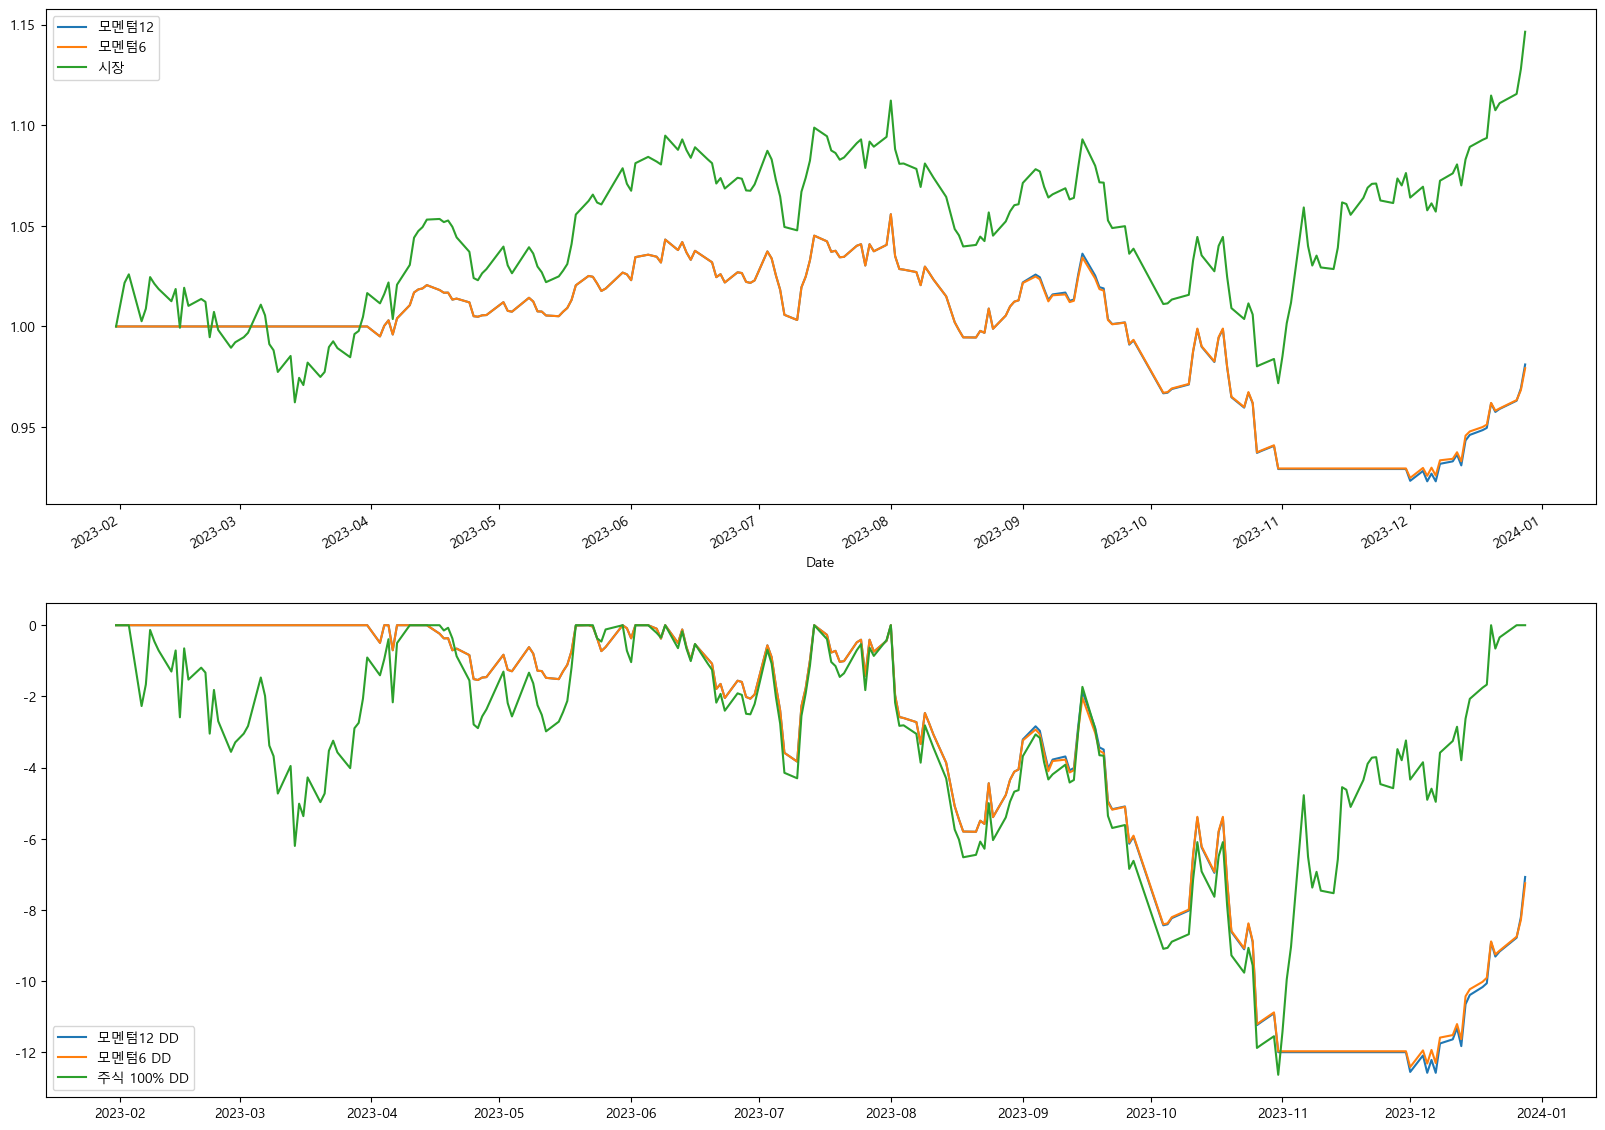

In [35]:
plt.rc('font', family='malgun gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(20,16))

# 수익곡선
plt.subplot(2,1,1)
momentum12CumReturn.plot(label="모멘텀12")
momentum6CumReturn.plot(label="모멘텀6")
stockCumReturn.plot(label="시장")
plt.legend()

# dd 곡선
plt.subplot(2,1,2)
plt.plot(-dd12, label="모멘텀12 DD")
plt.plot(-dd6, label="모멘텀6 DD")
plt.plot(-stockDD, label="주식 100% DD")
plt.legend()

plt.show()